# Apply Naive Bayes

<ol>
    **<li> Problem Description </li>**
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li>
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB`
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

In [ ]:
# For this assignment, I have taken multiple references from the internet but the major reference is the 'Reference Notebook (Applying KNN on donors choose dataset)' provided by AAIC
# Reference - https://colab.research.google.com/drive/1QE7c9oVfSwQcoLv8pxIqa6b9meiuqNgX

# importing required libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # for plotting various graphs/plots
import seaborn as sns  # for plotting confusion matrix heatmaps
from sklearn.feature_extraction.text import TfidfVectorizer  # for TFIDFs calculations
from sklearn.feature_extraction.text import CountVectorizer  # for BOW calculations
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm  # progress bar display
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Loading Data

In [ ]:
# mounting google drive (required csv files are present in the drive)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas
data = pandas.read_csv('/content/drive/MyDrive/preprocessed_data.csv', nrows=100000)  # reading the preprocessed data and taking 1 lakh data points for the assignment
data.head(5)  # printing first 5 rows of the data

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
y = data['project_is_approved'].values  # storing y labels (0 or 1) of the data in the variable 'y'
X = data.drop(['project_is_approved'], axis=1)  # removing the y labels corresponding column from the dataset
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
from sklearn.model_selection import train_test_split  # for spliting the data into train data, cv data, test data
# splitting 1 lakh points into 67k training points and 33k test points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)  # stratify=y will result in preservation of the proportions of the examples observed in original data, even in splitted data
# splitting 67k training points into 44890 final train points and 22110 cv points
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)  # reference for stratify - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
print(X_train.shape) # length of train data points
print(X_cv.shape) # length of cv data points
print(X_test.shape) # length of test data points

(44890, 8)
(22110, 8)
(33000, 8)


<h2>1.3 Make Data Model Ready: encoding essay</h2>

<h3>A] BOW representation</h3>

In [ ]:
# printing the shape of the data before BOW vectorization
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print('='*100)
# BOW vectorization(fit() and transform() methods used)
# CountVectorizer() used for BOW
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# min_df=10 means consider only those words which appeared in atleast 10 documents/rows
# ngram_range is set from 1 to 4 which means minimum 1 word should be there and maximum 4 words are allowed
# number of features is set to 5000 max
vectorizer = CountVectorizer(min_df=10, ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values)  # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output(words in BOW format)
# so transform() function can be used for train,cv,test data as there is no learning involved
bow_X_train_essay = vectorizer.transform(X_train['essay'].values)
bow_X_cv_essay = vectorizer.transform(X_cv['essay'].values)
bow_X_test_essay = vectorizer.transform(X_test['essay'].values)

# printing the shape of the data after BOW vectorization
print('After Bag of Words vectorization - ')
print(bow_X_train_essay.shape, y_train.shape)
print(bow_X_cv_essay.shape, y_cv.shape)
print(bow_X_test_essay.shape, y_test.shape)

print('='*100)

(44890, 8) (44890,)
(22110, 8) (22110,)
(33000, 8) (33000,)
After Bag of Words vectorization - 
(44890, 5000) (44890,)
(22110, 5000) (22110,)
(33000, 5000) (33000,)


<h3>B] TFIDF representation</h3>

In [ ]:
# printing the shape of the data before TFIDF vectorization
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print('='*100)
# TFIDF vectorization(fit() and transform() methods used)
# TfidfVectorizer() used for TFIDF
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# min_df=10 means consider only those words which appeared in atleast 10 documents/rows
# number of features is set to 5000 max
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_features=5000)
tfidf_vectorizer.fit(X_train['essay'].values)  # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output(words in tfidf format)
# so transform() function can be used for train,cv,test data as there is no learning involved
tfidf_X_train_essay = tfidf_vectorizer.transform(X_train['essay'].values)
tfidf_X_cv_essay = tfidf_vectorizer.transform(X_cv['essay'].values)
tfidf_X_test_essay = tfidf_vectorizer.transform(X_test['essay'].values)

# printing the shape of the data after TFIDF vectorization
print('After TFIDF vectorization - ')
print(tfidf_X_train_essay.shape, y_train.shape)
print(tfidf_X_cv_essay.shape, y_cv.shape)
print(tfidf_X_test_essay.shape, y_test.shape)

print('='*100)

(44890, 8) (44890,)
(22110, 8) (22110,)
(33000, 8) (33000,)
After TFIDF vectorization - 
(44890, 5000) (44890,)
(22110, 5000) (22110,)
(33000, 5000) (33000,)


<h2>1.4 Make Data Model Ready: encoding numerical features</h2>

<h3>A] Encoding numerical features - price</h3>

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
from sklearn.preprocessing import Normalizer  # to normalize the data values in between 0 to 1
normalizer_price = Normalizer()
# fit() function does nothing here
normalizer_price.fit(X_train['price'].values.reshape(1,-1))  # reshaping of the data is done to avoid an error(expected 2D array, got 1D array instead)
# reshape(-1,1) not used because it returns [[1],[1],[1],.....] instead of giving values between 0 to 1  # reference - https://imgur.com/ldZA1zg

# transform() scales each non zero row of the data to unit form(1) i.e. making values of the data cell ranging between 0 to 1
price_norm_X_train = normalizer_price.transform(X_train['price'].values.reshape(1,-1))
price_norm_X_cv = normalizer_price.transform(X_cv['price'].values.reshape(1,-1))
price_norm_X_test = normalizer_price.transform(X_test['price'].values.reshape(1,-1))

# after normalization is done, reshape(1,-1) to (-1,1), to avoid the shape mismatch problem
# reference - https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg
price_norm_X_train = price_norm_X_train.reshape(-1,1)
price_norm_X_cv = price_norm_X_cv.reshape(-1,1)
price_norm_X_test = price_norm_X_test.reshape(-1,1)

# printing the shape of the data after price vectorization
print('After price vectorization - ')
print(price_norm_X_train.shape, y_train.shape)
print(price_norm_X_cv.shape, y_cv.shape)
print(price_norm_X_test.shape, y_test.shape)
print('='*100)

After price vectorization - 
(44890, 1) (44890,)
(22110, 1) (22110,)
(33000, 1) (33000,)


<h3>B] Encoding numerical features - teacher_number_of_previously_posted_projects</h3>

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
normalizer_project = Normalizer() # to normalize the data values in between 0 to 1
# fit() function does nothing here
normalizer_project.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) # reshaping of the data is done to avoid an error(expected 2D array, got 1D array instead)
# reshape(-1,1) not used because it returns [[1],[1],[1],.....] instead of giving values between 0 to 1  # reference - https://imgur.com/ldZA1zg

# transform() scales each non zero row of the data to unit form(1) i.e. making values of the data cell ranging between 0 to 1
project_norm_X_train = normalizer_project.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
project_norm_X_cv = normalizer_project.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
project_norm_X_test = normalizer_project.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

# after normalization is done, reshape(1,-1) to (-1,1), to avoid the shape mismatch problem
# reference - https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg
project_norm_X_train = project_norm_X_train.reshape(-1,1)
project_norm_X_cv = project_norm_X_cv.reshape(-1,1)
project_norm_X_test = project_norm_X_test.reshape(-1,1)

# printing the shape of the data after teacher_number_of_previously_posted_projects vectorization
print('After teacher_number_of_previously_posted_projects vectorization - ')
print(project_norm_X_train.shape, y_train.shape)
print(project_norm_X_cv.shape, y_cv.shape)
print(project_norm_X_test.shape, y_test.shape)
print('='*100)

After teacher_number_of_previously_posted_projects vectorization - 
(44890, 1) (44890,)
(22110, 1) (22110,)
(33000, 1) (33000,)


<h2>1.5 Make Data Model Ready: encoding categorical features</h2>

<h3>A] Encoding categorical features - teacher_prefix</h3>

In [ ]:
# CountVectorizer() - converts texts to vector of token/word counts
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
teacher_vectorizer = CountVectorizer()
teacher_vectorizer.fit(X_train['teacher_prefix'].values)  # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output
# so transform() function can be used for train,cv,test data as there is no learning involved
teacher_pre_X_train = teacher_vectorizer.transform(X_train['teacher_prefix'].values)
teacher_pre_X_cv = teacher_vectorizer.transform(X_cv['teacher_prefix'].values)
teacher_pre_X_test = teacher_vectorizer.transform(X_test['teacher_prefix'].values)

# printing the shape of the data after teacher_prefix vectorization
print('After teacher_prefix vectorization - ')
print(teacher_pre_X_train.shape, y_train.shape)
print(teacher_pre_X_cv.shape, y_cv.shape)
print(teacher_pre_X_test.shape, y_test.shape)
print(teacher_vectorizer.get_feature_names())  # printing feature names present in teacher_prefix
print('='*100)

After teacher_prefix vectorization - 
(44890, 5) (44890,)
(22110, 5) (22110,)
(33000, 5) (33000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h3>B] Encoding categorical features - project_grade_category</h3>

In [ ]:
# CountVectorizer() - converts texts to vector of token/word counts
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
project_grade_vectorizer = CountVectorizer()
project_grade_vectorizer.fit(X_train['project_grade_category'].values) # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output
# so transform() function can be used for train,cv,test data as there is no learning involved
project_grade_X_train = project_grade_vectorizer.transform(X_train['project_grade_category'].values)
project_grade_X_cv = project_grade_vectorizer.transform(X_cv['project_grade_category'].values)
project_grade_X_test = project_grade_vectorizer.transform(X_test['project_grade_category'].values)

# printing the shape of the data after project_grade_category vectorization
print('After project_grade_category vectorization - ')
print(project_grade_X_train.shape, y_train.shape)
print(project_grade_X_cv.shape, y_cv.shape)
print(project_grade_X_test.shape, y_test.shape)
print(project_grade_vectorizer.get_feature_names())  # printing feature names present in project_grade_category
print('='*100)

After project_grade_category vectorization - 
(44890, 4) (44890,)
(22110, 4) (22110,)
(33000, 4) (33000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h3>C] Encoding categorical features - school_state</h3>

In [ ]:
# CountVectorizer() - converts texts to vector of token/word counts
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
school_state_vectorizer = CountVectorizer()
school_state_vectorizer.fit(X_train['school_state'].values) # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output
# so transform() function can be used for train,cv,test data as there is no learning involved
school_state_X_train = school_state_vectorizer.transform(X_train['school_state'].values)
school_state_X_cv = school_state_vectorizer.transform(X_cv['school_state'].values)
school_state_X_test = school_state_vectorizer.transform(X_test['school_state'].values)

# printing the shape of the data after school_state vectorization
print('After school_state vectorization - ')
print(school_state_X_train.shape, y_train.shape)
print(school_state_X_cv.shape, y_cv.shape)
print(school_state_X_test.shape, y_test.shape)
print(school_state_vectorizer.get_feature_names()) # printing feature names present in school_state
print('='*100)

After school_state vectorization - 
(44890, 51) (44890,)
(22110, 51) (22110,)
(33000, 51) (33000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>D] Encoding categorical features - clean_categories</h3>

In [ ]:
# CountVectorizer() - converts texts to vector of token/word counts
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
clean_categories_vectorizer = CountVectorizer()
clean_categories_vectorizer.fit(X_train['clean_categories'].values) # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output
# so transform() function can be used for train,cv,test data as there is no learning involved
clean_categories_X_train = clean_categories_vectorizer.transform(X_train['clean_categories'].values)
clean_categories_X_cv = clean_categories_vectorizer.transform(X_cv['clean_categories'].values)
clean_categories_X_test = clean_categories_vectorizer.transform(X_test['clean_categories'].values)

# printing the shape of the data after clean_categories vectorization
print('After clean_categories vectorization - ')
print(clean_categories_X_train.shape, y_train.shape)
print(clean_categories_X_cv.shape, y_cv.shape)
print(clean_categories_X_test.shape, y_test.shape)
print(clean_categories_vectorizer.get_feature_names()) # printing feature names present in clean_categories
print('='*100)

After clean_categories vectorization - 
(44890, 9) (44890,)
(22110, 9) (22110,)
(33000, 9) (33000,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


<h3>E] Encoding categorical features - clean_subcategories</h3>

In [ ]:
# CountVectorizer() - converts texts to vector of token/word counts
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
clean_subcategories_vectorizer = CountVectorizer()
clean_subcategories_vectorizer.fit(X_train['clean_subcategories'].values) # fit() learns the vocabulary of text # so fit() is used only for train data

# transform() will apply learned parameters from fit() function to the data and give output
# so transform() function can be used for train,cv,test data as there is no learning involved
clean_subcategories_X_train = clean_subcategories_vectorizer.transform(X_train['clean_subcategories'].values)
clean_subcategories_X_cv = clean_subcategories_vectorizer.transform(X_cv['clean_subcategories'].values)
clean_subcategories_X_test = clean_subcategories_vectorizer.transform(X_test['clean_subcategories'].values)

# printing the shape of the data after clean_subcategories vectorization
print('After clean_subcategories vectorization - ')
print(clean_subcategories_X_train.shape, y_train.shape)
print(clean_subcategories_X_cv.shape, y_cv.shape)
print(clean_subcategories_X_test.shape, y_test.shape)
print(clean_subcategories_vectorizer.get_feature_names()) # printing feature names present in clean_subcategories
print('='*100)

After clean_subcategories vectorization - 
(44890, 30) (44890,)
(22110, 30) (22110,)
(33000, 30) (33000,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


<h2>1.6 Concatenating all the features</h2>

<h3>A] Concatenation for Set 1 - categorical, numerical features + preprocessed_essay (BOW)</h3>

In [ ]:
# hstack() used to stack sparse matrices horizontally (column wise)
# reference - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html
from scipy.sparse import hstack
# for train data
X_train_s1 = hstack((bow_X_train_essay, price_norm_X_train, project_norm_X_train, teacher_pre_X_train, project_grade_X_train, school_state_X_train, clean_categories_X_train, clean_subcategories_X_train)).tocsr()
# for cross validation data
X_cv_s1 = hstack((bow_X_cv_essay, price_norm_X_cv, project_norm_X_cv, teacher_pre_X_cv, project_grade_X_cv, school_state_X_cv, clean_categories_X_cv, clean_subcategories_X_cv)).tocsr()
# for test data
X_test_s1 = hstack((bow_X_test_essay, price_norm_X_test, project_norm_X_test, teacher_pre_X_test, project_grade_X_test, school_state_X_test, clean_categories_X_test, clean_subcategories_X_test)).tocsr()

# printing the stacked matrix for train,cv,test data (all the features stacked for Set 1)
print('Final Data Matrix for Set 1 - ')
print(X_train_s1.shape, y_train.shape)
print(X_cv_s1.shape, y_cv.shape)
print(X_test_s1.shape, y_test.shape)
print('='*100)

Final Data Matrix for Set 1 - 
(44890, 5101) (44890,)
(22110, 5101) (22110,)
(33000, 5101) (33000,)


<h3>B] Concatenation for Set 2 - categorical, numerical features + preprocessed_essay (TFIDF)</h3>

In [ ]:
# hstack() used to stack sparse matrices horizontally (column wise)
# reference - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html
from scipy.sparse import hstack
# for train data
X_train_s2 = hstack((tfidf_X_train_essay, price_norm_X_train, project_norm_X_train, teacher_pre_X_train, project_grade_X_train, school_state_X_train, clean_categories_X_train, clean_subcategories_X_train)).tocsr()
# for cv data
X_cv_s2 = hstack((tfidf_X_cv_essay, price_norm_X_cv, project_norm_X_cv, teacher_pre_X_cv, project_grade_X_cv, school_state_X_cv, clean_categories_X_cv, clean_subcategories_X_cv)).tocsr()
# for test data
X_test_s2 = hstack((tfidf_X_test_essay, price_norm_X_test, project_norm_X_test, teacher_pre_X_test, project_grade_X_test, school_state_X_test, clean_categories_X_test, clean_subcategories_X_test)).tocsr()

# printing the stacked matrix for train,cv,test data (all the features stacked for Set 2)
print('Final Data Matrix for Set 2 - ')
print(X_train_s2.shape, y_train.shape)
print(X_cv_s2.shape, y_cv.shape)
print(X_test_s2.shape, y_test.shape)
print('='*100)

Final Data Matrix for Set 2 - 
(44890, 5101) (44890,)
(22110, 5101) (22110,)
(33000, 5101) (33000,)


<h2>1.7 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

<h3>A] Applying Naive Bayes on Set 1 - categorical, numerical features + preprocessed_essay (BOW)</h3>

In [ ]:
# batch_predict() function defined for batchwise prediction of data. Data is divided into batches of size 1000
def batch_predict(classifier, data):  # classifier will be MultinomialNB() and data will be either of set 1 or set 2
  predicted_probas_positive = []  # empty list to store predicted probability values of positive class(y=1)
  data_loop = data.shape[0] - data.shape[0]%1000 # data_loop value obtained will be a 1000 multiplier
  for i in range(0, data_loop, 1000): # looping through all the data  points till max 1000 multiplier
    predicted_probas_positive.extend(classifier.predict_proba(data[i:i+1000])[:,1])  # extend() add all the elements to the end of the list # [:,1] returns predicted probabilty of positive class
  if data.shape[0]%1000 != 0:  # for the remaining data points
    predicted_probas_positive.extend(classifier.predict_proba(data[data_loop:])[:,1]) # extend() reference - https://www.programiz.com/python-programming/methods/list/extend#:~:text=List%20index()-,Python%20List%20extend(),the%20end%20of%20the%20list.&text=Here%2C%20all%20the%20elements%20of,to%20the%20end%20of%20list1%20.

  return predicted_probas_positive

**1.7.1 Hyperparameter tuning methods(here hyperparameter is alpha)**

*Method 1 : Simple For loop*

100%|██████████| 9/9 [00:00<00:00, 44992.53it/s]


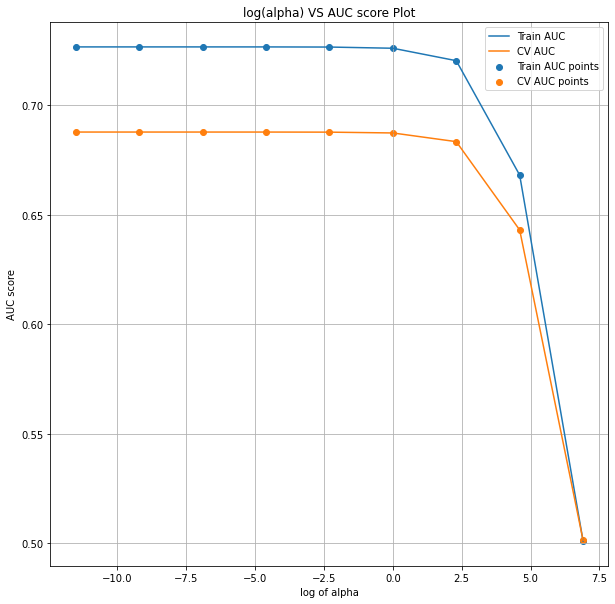

In [ ]:
# importing required libraries
from sklearn.naive_bayes import MultinomialNB  # MultinomialNB() classifier
from sklearn.metrics import roc_auc_score  # to calculate score of roc-auc curve
import math  # to find log of value

train_auc = []  # empty list to store auc score of train data
cv_auc = []  # empty list to store auc score of cv data
log_of_alphas = []  # empty list to store lof of alpha values provided

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]  # α values from 10⁻⁵ to 10³

for i in tqdm(alpha_values):  # looping through the α values  # tqdm used to show the progress bar of for loop
  multi_nb = MultinomialNB(alpha = i, class_prior=[0.5,0.5])  # class_prior - prior probabilities of the classes # reference - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
  multi_nb.fit(X_train_s1, y_train)  # fitting on set 1 training data
  y_train_predict = batch_predict(multi_nb, X_train_s1)  # batchwise prediction for set 1 train data
  y_cv_predict = batch_predict(multi_nb, X_cv_s1)  # batchwise prediction for set 1 cv data

  # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
  # not the predicted outputs
  train_auc.append(roc_auc_score(y_train, y_train_predict))  # storing the auc score in train_auc list
  cv_auc.append(roc_auc_score(y_cv, y_cv_predict))  # storing the auc score in cv_auc list

for j in tqdm(alpha_values):  # looping through the α values  # tqdm used to show the progress bar of for loop
  k = math.log(j) # taking log value of α values as the range of α values is huge and we need to plot all of them
  log_of_alphas.append(k)  # storing log of α values in the list

# plotting log(α) VS AUC score Plot
plt.figure(figsize=(10,10))
plt.plot(log_of_alphas, train_auc, label='Train AUC')  # Train data curve
plt.plot(log_of_alphas, cv_auc, label='CV AUC')  # CV data curve

plt.scatter(log_of_alphas, train_auc, label='Train AUC points')  # train data points on the curve
plt.scatter(log_of_alphas, cv_auc, label='CV AUC points')  # CV data points on the curve

plt.legend()
plt.xlabel('log of alpha')  # X axis label
plt.ylabel('AUC score')  # Y axis label
plt.title('log(alpha) VS AUC score Plot')
plt.grid()
plt.show()

Observation - <br>


*   log of alpha values taken to accomodate all the alpha values in the plot.
*   Both the train curve as well as CV curve converges at log(alpha)=7 with AUC score=0.5.



*Method 2 : k-fold cross validation using GridSearchCV*

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV
from sklearn.model_selection import GridSearchCV  # for k fold cross validation of the data

multi_nb = MultinomialNB(class_prior=[0.5,0.5]) # class_prior - prior probabilities of the classes
params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]} # α values from 10⁻⁵ to 10³

gridsearch = GridSearchCV(multi_nb, params, cv=10, scoring='roc_auc', return_train_score=True, verbose=2)  # cross validation of data done using GridSearchCV() with cv=10 folds
# verbose is set to 2, to display progress messages  # scoring - strategy to evaluate the performance of the cross-validated model on the test set.
gridsearch.fit(X_train_s1, y_train) # fitting on set 1 training data # CV data not used while using k-fold cross validation

train_auc= gridsearch.cv_results_['mean_train_score']  # mean/average auc score of train data
train_auc_std= gridsearch.cv_results_['std_train_score']  # standard deviation of auc score of train data
cv_auc = gridsearch.cv_results_['mean_test_score']  # mean/average auc score of cv data
cv_auc_std= gridsearch.cv_results_['std_test_score']  # standard deviation of auc score of cv data

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   12.3s finished


100%|██████████| 9/9 [00:00<00:00, 8569.52it/s]


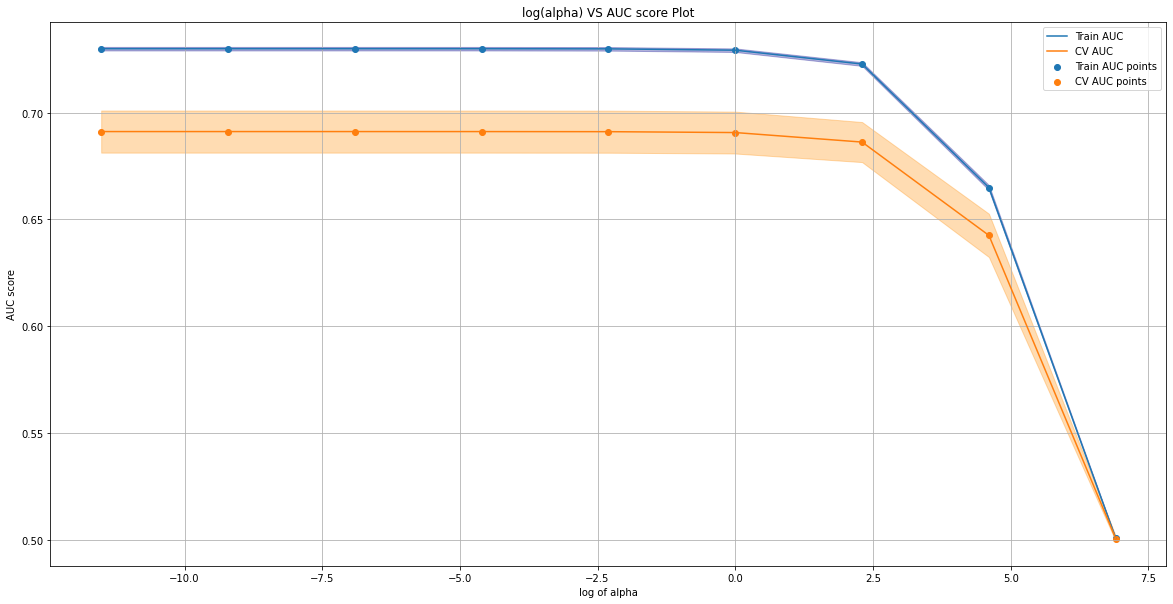

In [ ]:
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000] # α values from 10⁻⁵ to 10³
log_of_alphas = []  # empty list to store lof of alpha values provided

for i in tqdm(alpha_values): # looping through the α values  # tqdm used to show the progress bar of for loop
  j = math.log(i) # taking log value of α values as the range of α values is huge and we need to plot all of them
  log_of_alphas.append(j)  # storing log of α values in the list

# plotting log(α) VS AUC score Plot
plt.figure(figsize=(20,10))
plt.plot(log_of_alphas, train_auc, label='Train AUC')  # train data curve

# plotting mean and std deviation of train data # reference - https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361
plt.gca().fill_between(log_of_alphas, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_of_alphas, cv_auc, label='CV AUC')  # cv data curve

# plotting mean and std deviation of cv data # reference - https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361
plt.gca().fill_between(log_of_alphas, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_of_alphas, train_auc, label='Train AUC points') # train data points on the curve
plt.scatter(log_of_alphas, cv_auc, label='CV AUC points') # cv data points on the curve

plt.legend()
plt.xlabel('log of alpha')  # X axis label
plt.ylabel('AUC score')  # Y axis label
plt.title('log(alpha) VS AUC score Plot')
plt.grid()
plt.show()

Observation - <br>


*   log of alpha values taken to accomodate all the alpha values in the plot.
*   Both the train curve as well as CV curve converges at log(alpha)=7 with AUC score=0.5.



In [ ]:
# reference - https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
print('Optimal hyperparameter alpha is - ', gridsearch.best_params_)  # printing the best/optimal value of alpha
# NOTE - to obtain best_params_, estimator is fitted first(e.g. gridsearch.fit()) which we have done above

Optimal hyperparameter alpha is -  {'alpha': 0.0001}


**1.7.2 Using the optimal hyperparameter value and training the model**

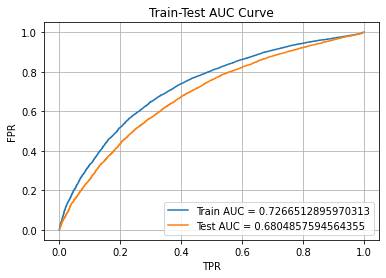

In [ ]:
multi_nb_bow = MultinomialNB(alpha = 0.0001, class_prior=[0.5,0.5])  # passing the alpha value obtained in the classifier
multi_nb_bow.fit(X_train_s1, y_train) # classifier fitted using fit() on set 1 train data and training the model

y_train_predict = batch_predict(multi_nb_bow, X_train_s1) # batchwise prediction for set 1 train data
y_test_predict = batch_predict(multi_nb_bow, X_test_s1) # batchwise prediction for set 1 test data

fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_predict) # computing roc of train data and assigning value to train's fpr,tpr,threshold
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_predict)  # computing roc of test data and assigning value to test's fpr,tpr,threshold

# plotting train-test auc curve
plt.plot(fpr_train, tpr_train, label='Train AUC = '+str(auc(fpr_train, tpr_train))) # plotting train auc curve using tpr,fpr values of train data
plt.plot(fpr_test, tpr_test, label='Test AUC = '+str(auc(fpr_test, tpr_test))) # plotting test auc curve using tpr,fpr values of test data

plt.legend()
plt.xlabel('TPR') # X axis label
plt.ylabel('FPR') # Y axis label
plt.title('Train-Test AUC Curve')
plt.grid()
plt.show()

Obsrvation - For Set 1(alpha=0.0001) <br>


*   Train AUC score obtained is 0.72
*   Test AUC score obtained is 0.68



**1.7.3 Confusion matrix**

In [ ]:
# function to calculate best threshold which will give maximum value of tpr*(1-fpr)
def best_threshold(threshold, fpr, tpr):
  t = threshold[np.argmax(tpr*(1-fpr))]  # (tpr*(1-fpr)) will be maximum if fpr is very low and tpr is very high  # yeild the corresponding threshold
  print('The maximum value of tpr*(1-fpr) is ', max(tpr*(1-fpr)), 'for threshold ', np.round(t,3))
  return t

# function to predict the data points with best threshold obtained from above function
def predict_with_best_threshold(proba, threshold):
  predictions = []  # empty list to store predicted outputs
  for i in proba: # looping through the predicted probabilty values of train,test data
    if i >= threshold:  # predicted probability greater than best threshold obtained
      predictions.append(1)  # append data point as positive(1)
    else:  # predicted probability less than best threshold obtained
      predictions.append(0)  # append data point as negative(0)
  return predictions

*Train Data Confusion matrix*

In [ ]:
from sklearn.metrics import confusion_matrix  # to compute confusion matrix of the dataset

best_threshold_value = best_threshold(threshold_train, fpr_train, tpr_train)  # giving training data parameters to calculate best threshold value
print('Train Data Confusion Matrix - ')
print(confusion_matrix(y_train, predict_with_best_threshold(y_train_predict, best_threshold_value))) # printing the confusion matrix with tp,fp,tn,fn values of train data

The maximum value of tpr*(1-fpr) is  0.45440585216927454 for threshold  0.404
Train Data Confusion Matrix - 
[[ 4542  2274]
 [12111 25963]]


In [ ]:
train_conf_matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_threshold(y_train_predict, best_threshold_value)), range(2), range(2)) # assigning a variable to the confusion matrix

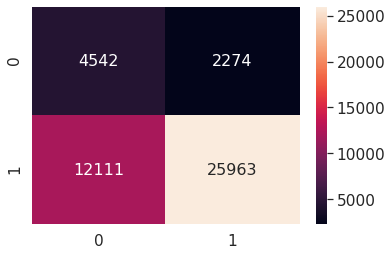

In [ ]:
# reference - https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
sns.set(font_scale=1.4)
sns.heatmap(train_conf_matrix_df, annot=True, annot_kws={'size':16}, fmt='g')  # fmt='g' used to fix values displayed in confusion matrix in exponential form to normal form

Observation - <br>


*   Train data confusion matrix is having large number of True Positive values(TP=25963) whereas it has less number of True Negative values(TN=4542).
*   There are large number of False Negative values(FN=12111) which means model predicted those points to be Negative points but actually they are positive points. This happens data data imbalance(huge number of positive points compared to negative points).



*Test Data Confusion Matrix*

In [ ]:
best_threshold_value_test = best_threshold(threshold_test, fpr_test, tpr_test) # giving test data parameters to calculate best threshold value
print('Test Data Confusion Matrix - ')
print(confusion_matrix(y_test, predict_with_best_threshold(y_test_predict, best_threshold_value_test))) # printing the confusion matrix with tp,fp,tn,fn values of test data

The maximum value of tpr*(1-fpr) is  0.40545333769759523 for threshold  0.583
Test Data Confusion Matrix - 
[[ 3189  1821]
 [10161 17829]]


In [ ]:
test_conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_threshold(y_test_predict, best_threshold_value_test)), range(2), range(2)) # assigning a variable to the confusion matrix

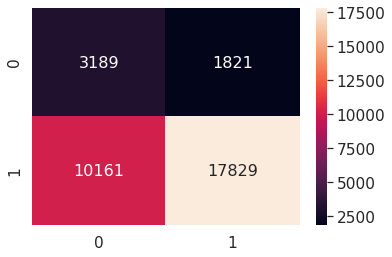

In [ ]:
# reference - https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor
sns.set(font_scale=1.4)
sns.heatmap(test_conf_matrix_df, annot=True, annot_kws={'size':16}, fmt='g') # fmt='g' used to fix values displayed in confusion matrix in exponential form to normal form

Observation - <br>


*   Test data confusion matrix is having large number of True Positive values(TP=17829) whereas it has less number of True Negative values(TN=3189).
*   There are large number of False Negative values(FN=10161) which means model predicted those points to be Negative points but actually they are positive points. This happens data data imbalance(huge number of positive points compared to negative points).



<h3>B] Applying Naive Bayes on Set 2 - categorical, numerical features + preprocessed_essay (TFIDF)</h3>

**1.7.4 Hyperparameter tuning methods(here hyperparameter is alpha)**

*Method 1 : Simple For loop*

100%|██████████| 9/9 [00:00<00:00, 16563.73it/s]


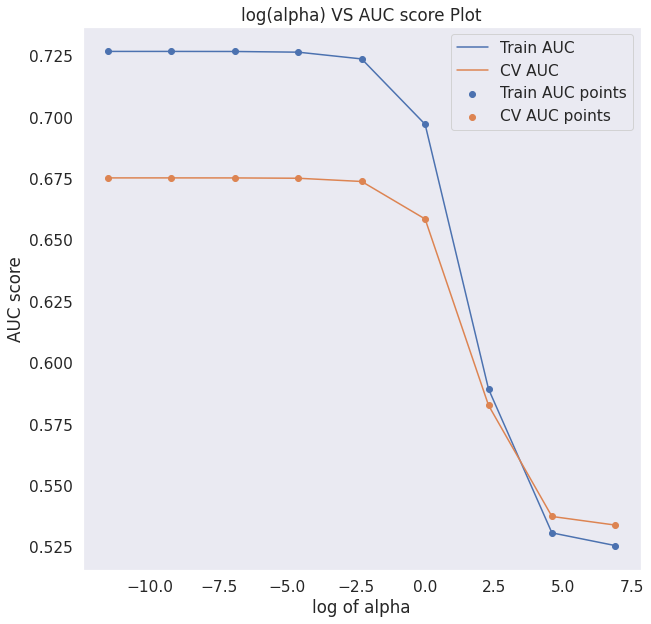

In [ ]:
# importing required libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = [] # empty list to store auc score of train data
cv_auc = [] # empty list to store auc score of cv data
log_of_alphas = [] # empty list to store lof of alpha values provided

alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000] # α values from 10⁻⁵ to 10³

for i in tqdm(alpha_values): # looping through the α values  # tqdm used to show the progress bar of for loop
  multi_nb = MultinomialNB(alpha = i, class_prior=[0.5,0.5]) # class_prior - prior probabilities of the classes # reference - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
  multi_nb.fit(X_train_s2, y_train) # fitting on set 2 training data
  y_train_predict = batch_predict(multi_nb, X_train_s2) # batchwise prediction for set 2 train data
  y_cv_predict = batch_predict(multi_nb, X_cv_s2) # batchwise prediction for set 2 cv data

  train_auc.append(roc_auc_score(y_train, y_train_predict)) # storing the auc score in train_auc list
  cv_auc.append(roc_auc_score(y_cv, y_cv_predict)) # storing the auc score in cv_auc list

for j in tqdm(alpha_values): # looping through the α values  # tqdm used to show the progress bar of for loop
  k = math.log(j) # taking log value of α values as the range of α values is huge and we need to plot all of them
  log_of_alphas.append(k) # storing log of α values in the list

# plotting log(α) VS AUC score Plot
plt.figure(figsize=(10,10))
plt.plot(log_of_alphas, train_auc, label='Train AUC')
plt.plot(log_of_alphas, cv_auc, label='CV AUC')

plt.scatter(log_of_alphas, train_auc, label='Train AUC points')
plt.scatter(log_of_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel('log of alpha')
plt.ylabel('AUC score')
plt.title('log(alpha) VS AUC score Plot')
plt.grid()
plt.show()

Observation - <br>


*   log of alpha values taken to accomodate all the alpha values in the plot.
*   Both the train curve as well as CV curve almost converges at log(alpha)=3 with AUC score near to 0.55.



*Method 2 : k-fold cross validation using GridSearchCV*

In [ ]:
from sklearn.model_selection import GridSearchCV # for k fold cross validation of the data

multi_nb = MultinomialNB(class_prior=[0.5,0.5]) # class_prior - prior probabilities of the classes
params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]} # α values from 10⁻⁵ to 10³

gridsearch = GridSearchCV(multi_nb, params, cv=10, scoring='roc_auc', return_train_score=True, verbose=2) # cross validation of data done using GridSearchCV() with cv=10 folds
# verbose is set to 2, to display progress messages  # scoring - strategy to evaluate the performance of the cross-validated model on the test set.
gridsearch.fit(X_train_s2, y_train) # fitting on set 2 training data # CV data not used while using k-fold cross validation

train_auc= gridsearch.cv_results_['mean_train_score'] # mean/average auc score of train data
train_auc_std= gridsearch.cv_results_['std_train_score'] # standard deviation of auc score of train data
cv_auc = gridsearch.cv_results_['mean_test_score'] # mean/average auc score of cv data
cv_auc_std= gridsearch.cv_results_['std_test_score'] # standard deviation of auc score of cv data

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.6s finished


100%|██████████| 9/9 [00:00<00:00, 2305.27it/s]


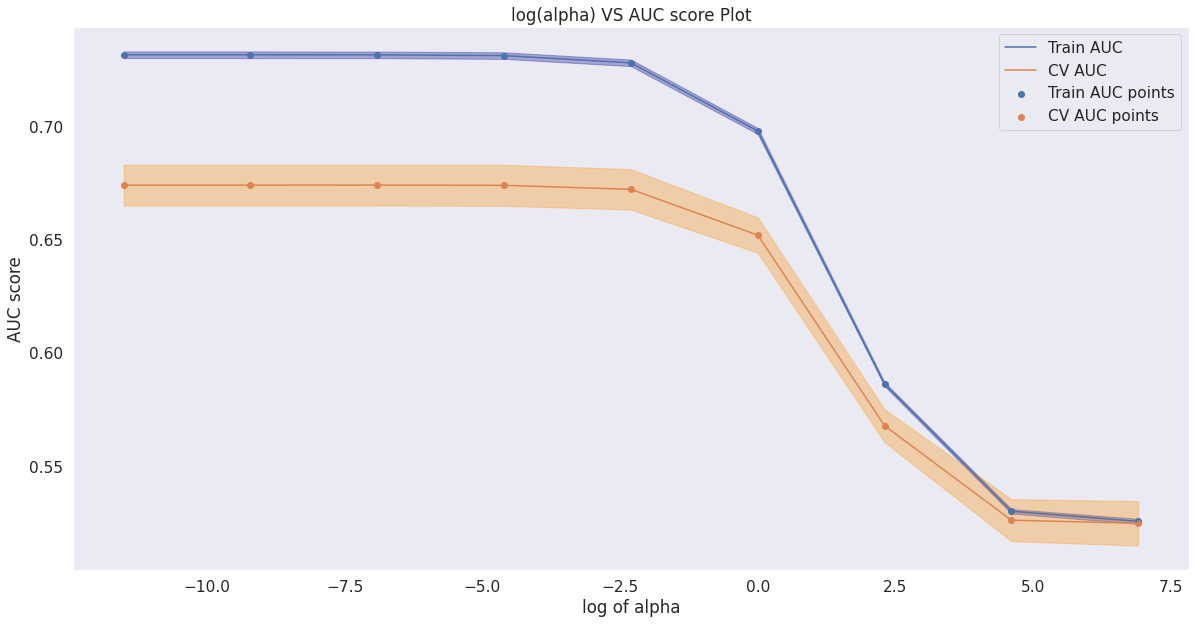

In [ ]:
alpha_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10,  100,  1000]
log_of_alphas = [] # empty list to store lof of alpha values provided

for i in tqdm(alpha_values):
  j = math.log(i)
  log_of_alphas.append(j)

# plotting log(α) VS AUC score Plot
plt.figure(figsize=(20,10))
plt.plot(log_of_alphas, train_auc, label='Train AUC')

# plotting mean and std deviation of train data # reference - https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361
plt.gca().fill_between(log_of_alphas, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_of_alphas, cv_auc, label='CV AUC')

# plotting mean and std deviation of cv data # reference - https://stackoverflow.com/questions/48796282/how-to-visualize-dependence-of-model-performance-alpha-with-matplotlib/48803361#48803361
plt.gca().fill_between(log_of_alphas, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_of_alphas, train_auc, label='Train AUC points')
plt.scatter(log_of_alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel('log of alpha')
plt.ylabel('AUC score')
plt.title('log(alpha) VS AUC score Plot')
plt.grid()
plt.show()

Observation - <br>


*   log of alpha values taken to accomodate all the alpha values in the plot.
*   Both the train curve as well as CV curve converges at log(alpha)=7 with AUC score=0.5.



In [ ]:
print('Optimal hyperparameter alpha is - ', gridsearch.best_params_) # printing the best/optimal value of alpha
# NOTE - to obtain best_params_, estimator is fitted first(e.g. gridsearch.fit()) which we have done above

Optimal hyperparameter alpha is -  {'alpha': 0.001}


**1.7.5 Using the optimal hyperparameter value and training the model**

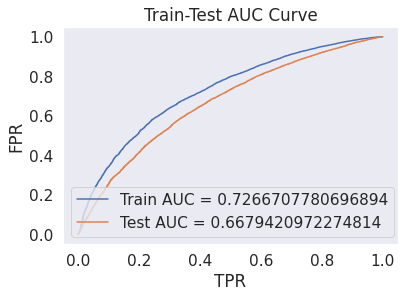

In [ ]:
multi_nb_bow = MultinomialNB(alpha = 0.001, class_prior=[0.5,0.5]) # passing the alpha value obtained in the classifier
multi_nb_bow.fit(X_train_s2, y_train) # classifier fitted using fit() on set 2 train data and training the model

y_train_predict = batch_predict(multi_nb_bow, X_train_s2) # batchwise prediction for set 2 train data
y_test_predict = batch_predict(multi_nb_bow, X_test_s2) # batchwise prediction for set 2 test data

fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_predict) # computing roc of train data and assigning value to train's fpr,tpr,threshold
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_predict) # computing roc of test data and assigning value to test's fpr,tpr,threshold

plt.plot(fpr_train, tpr_train, label='Train AUC = '+str(auc(fpr_train, tpr_train))) # plotting train auc curve using tpr,fpr values of train data
plt.plot(fpr_test, tpr_test, label='Test AUC = '+str(auc(fpr_test, tpr_test))) # plotting test auc curve using tpr,fpr values of test data

plt.legend()
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title('Train-Test AUC Curve')
plt.grid()
plt.show()

Obsrvation - For Set 2(alpha=0.001) <br>


*   Train AUC score obtained is 0.72
*   Test AUC score obtained is 0.66



**1.7.6 Confusion matrix**

*Train Data Confusion Matrix*

In [ ]:
from sklearn.metrics import confusion_matrix

best_threshold_value = best_threshold(threshold_train, fpr_train, tpr_train) # giving training data parameters to calculate best threshold value
print('Train Data Confusion Matrix - ')
print(confusion_matrix(y_train, predict_with_best_threshold(y_train_predict, best_threshold_value))) # printing the confusion matrix with tp,fp,tn,fn values of train data

The maximum value of tpr*(1-fpr) is  0.4479712921908189 for threshold  0.516
Train Data Confusion Matrix - 
[[ 4761  2055]
 [13656 24418]]


In [ ]:
train_conf_matrix_df = pd.DataFrame(confusion_matrix(y_train, predict_with_best_threshold(y_train_predict, best_threshold_value)), range(2), range(2)) # assigning a variable to the confusion matrix

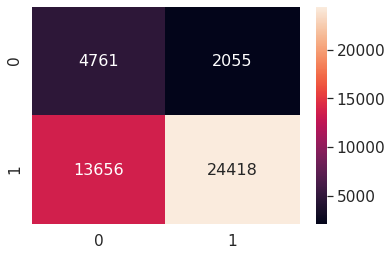

In [ ]:
sns.set(font_scale=1.4)
sns.heatmap(train_conf_matrix_df, annot=True, annot_kws={'size':16}, fmt='g') # fmt='g' used to fix values displayed in confusion matrix in exponential form to normal form

Observation - <br>


*   Train data confusion matrix is having large number of True Positive values(TP=24418) whereas it has less number of True Negative values(TN=4761).
*   There are large number of False Negative values(FN=13656) which means model predicted those points to be Negative points but actually they are positive points. This happens data data imbalance(huge number of positive points compared to negative points).



Test Data Confusion Matrix

In [ ]:
best_threshold_value_test = best_threshold(threshold_test, fpr_test, tpr_test) # giving test data parameters to calculate best threshold value
print('Test Data Confusion Matrix - ')
print(confusion_matrix(y_test, predict_with_best_threshold(y_test_predict, best_threshold_value_test))) # printing the confusion matrix with tp,fp,tn,fn values of test data

The maximum value of tpr*(1-fpr) is  0.39122180077144747 for threshold  0.523
Test Data Confusion Matrix - 
[[ 3222  1788]
 [10963 17027]]


In [ ]:
test_conf_matrix_df = pd.DataFrame(confusion_matrix(y_test, predict_with_best_threshold(y_test_predict, best_threshold_value_test)), range(2), range(2)) # assigning a variable to the confusion matrix

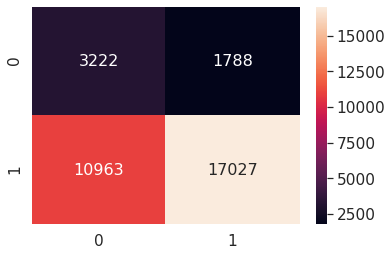

In [ ]:
sns.set(font_scale=1.4)
sns.heatmap(test_conf_matrix_df, annot=True, annot_kws={'size':16}, fmt='g') # fmt='g' used to fix values displayed in confusion matrix in exponential form to normal form

Observation - <br>


*   Test data confusion matrix is having large number of True Positive values(TP=17027) whereas it has less number of True Negative values(TN=3222).
*   There are large number of False Negative values(FN=10963) which means model predicted those points to be Negative points but actually they are positive points. This happens data data imbalance(huge number of positive points compared to negative points).



<h2>1.8 Find the top 20 features either from feature Set 1 or feature Set 2 </h2>

*I am going to find top 20 features for feature Set 1*

**Set 1 - BOW**

In [ ]:
# hstack() used to stack sparse matrices horizontally (column wise)
# reference - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.hstack.html

# for train data
X_train_s1 = hstack((bow_X_train_essay, price_norm_X_train, project_norm_X_train, teacher_pre_X_train, project_grade_X_train, school_state_X_train, clean_categories_X_train, clean_subcategories_X_train)).tocsr()
# for cv data
X_cv_s1 = hstack((bow_X_cv_essay, price_norm_X_cv, project_norm_X_cv, teacher_pre_X_cv, project_grade_X_cv, school_state_X_cv, clean_categories_X_cv, clean_subcategories_X_cv)).tocsr()
# for test data
X_test_s1 = hstack((bow_X_test_essay, price_norm_X_test, project_norm_X_test, teacher_pre_X_test, project_grade_X_test, school_state_X_test, clean_categories_X_test, clean_subcategories_X_test)).tocsr()

In [ ]:
multi_nb_bow = MultinomialNB(alpha = 0.0001, class_prior=[0.5,0.5])  # classifier with best alpha obtained
multi_nb_bow.fit(X_train_s1, y_train) # training the model on set 1 using fit() function

MultinomialNB(alpha=0.0001, class_prior=[0.5, 0.5], fit_prior=True)

In [ ]:
feature_names_bow = [] # empty list to store feature names which were generated using BOW

for count1 in teacher_vectorizer.get_feature_names(): # looping through teacher_vectorizer
  feature_names_bow.append(count1) # storing feature names of teacher_vectorizer

for count2 in project_grade_vectorizer.get_feature_names(): # looping through project_grade_vectorizer
  feature_names_bow.append(count2) # storing feature names of project_grade_vectorizer

for count3 in school_state_vectorizer.get_feature_names(): # looping through school_state_vectorizer
  feature_names_bow.append(count3) # storing feature names of school_state_vectorizer

for count4 in clean_categories_vectorizer.get_feature_names(): # looping through clean_categories_vectorizer
  feature_names_bow.append(count4) # storing feature names of clean_categories_vectorizer

for count5 in clean_subcategories_vectorizer.get_feature_names(): # looping through clean_subcategories_vectorizer
  feature_names_bow.append(count5) # storing feature names of clean_subcategories_vectorizer

for count6 in vectorizer.get_feature_names(): # looping through essay_vectorizer
  feature_names_bow.append(count6) # storing feature names of essay_vectorizer

feature_names_bow.append('price') # storing column name 'price'
feature_names_bow.append('teacher_number_of_previously_posted_projects') # storing column name 'teacher_number_of_previously_posted_projects'

In [ ]:
len(feature_names_bow) # printing total number of features present in the list

5101

**A] Top 20 positive features - BOW**

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# we need to sort in descending order. for that [::-1] used. # reference - mhttps://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
positive_class_probas = multi_nb_bow.feature_log_prob_[1, :].argsort()[::-1][:5101] # [1,:] gives feature log probabilites for positive class
for i in positive_class_probas[:20]: # looping through the positive class probabilities and taking 20 features only
  print(feature_names_bow[i]) # printing the top 20 positive features

spelling
relationships
meet needs students
kit
centered
supports
technology engineering
my students want
middle school students
it goal
grade reading
love lots
motivate students
useful
project help students
we able
moved
time students
leveled books
mathematics


**B] Top 20 negative features - BOW**

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# we need to sort in descending order. for that [::-1] used. # reference - mhttps://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
negative_class_probas = multi_nb_bow.feature_log_prob_[0, :].argsort()[::-1][:5101] # [0,:] gives feature log probabilites for negative class
for i in negative_class_probas[:20]: # looping through the ngeative class probabilities and taking 20 features only
  print(feature_names_bow[i]) # printing the top 20 negative features

spelling
relationships
kit
meet needs students
centered
my students want
it goal
technology engineering
supports
grade reading
middle school students
motivate students
love lots
useful
moved
we able
class this
leveled books
project help students
mathematics


Set 1 Observation (Top 20 words) - <br>


*   Most of the words can be found in both the lists of positive and negative features but their relative order is not same.
*   '*time students*' word is present only in the positive feature list whereas '*class this*' word is present only in negative feature list.



<h1>3. Summary(Table Format)</h1>


In [ ]:
# PrettyTable() used to summarize the data in tabular format
# reference - https://pypi.org/project/prettytable/
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Vectorizer', 'Model', 'Optimal alpha', 'Test AUC'] # column names provided

table.add_row(['BOW', 'Naive Bayes', '0.0001', '0.68']) # filling corresponding values to the column names (first row)
table.add_row(['TFIDF', 'Naive Bayes', '0.001', '0.66']) # filling corresponding values to the column names (second row)

print(table)

+------------+-------------+---------------+----------+
| Vectorizer |    Model    | Optimal alpha | Test AUC |
+------------+-------------+---------------+----------+
|    BOW     | Naive Bayes |     0.0001    |   0.68   |
|   TFIDF    | Naive Bayes |     0.001     |   0.66   |
+------------+-------------+---------------+----------+


Conclusion - <br>

*   Set 1 (BOW) has slightly better Test AUC than Set 2(TFIDF).
*   Naive Bayes is interpretable model and feature importance can be easily obtained for the features.

